In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import math
import copy

# The deformation module library is not automatically installed yet, we need to add its path manually
import sys
sys.path.append("../../")

import numpy as np
import matplotlib.pyplot as plt
import torch

import implicitmodules.torch as dm

torch.set_default_tensor_type(torch.FloatTensor)

dm.Utilities.set_compute_backend('torch')
device = 'cpu'

In [2]:
# Loading the datasets
try:
    data = pickle.load(open("../../data/data_acropetal.pkl", 'rb'))
except:
    print("Could not load the file.")

pos_source = torch.tensor(data['source_silent']).type(torch.get_default_dtype())
pos_implicit0 = torch.tensor(data['source_implicit0']).type(torch.get_default_dtype())
pos_implicit1 = torch.tensor(data['source_implicit1']).type(torch.get_default_dtype())
pos_target = torch.tensor(data['target_silent']).type(torch.get_default_dtype())

# Some rescaling for the source
Dx = 0.
Dy = 0.
height_source = 90.
height_target = 495.
dec = 150
smin, smax = torch.min(pos_source[:, 1]), torch.max(pos_source[:, 1])
sscale = height_source / (smax - smin)
pos_source[:, 0] = Dx + sscale * (pos_source[:, 0] - torch.mean(pos_source[:, 0]))
pos_source[:, 1] = Dy - sscale * (pos_source[:, 1] - smax) + dec
pos_implicit0[:, 0] = Dx + sscale * (pos_implicit0[:, 0] - torch.mean(pos_implicit0[:, 0]))
pos_implicit0[:, 1] = Dy - sscale * (pos_implicit0[:, 1] - smax) + dec
pos_implicit1[:, 0] = Dx + sscale * (pos_implicit1[:, 0] - torch.mean(pos_implicit1[:, 0]))
pos_implicit1[:, 1] = Dy - sscale * (pos_implicit1[:, 1] - smax) + dec
pos_implicit0 = pos_source.clone()
# Some rescaling for the target
tmin, tmax = torch.min(pos_target[:, 1]), torch.max(pos_target[:, 1])
tscale = height_target / (tmax - tmin)
pos_target[:, 0] = tscale * (pos_target[:, 0] - torch.mean(pos_target[:, 0]))
pos_target[:, 1] = - tscale * (pos_target[:, 1] - tmax)

# Compute an AABB for plotting
aabb = dm.Utilities.AABB.build_from_points(pos_target)
aabb.squared()

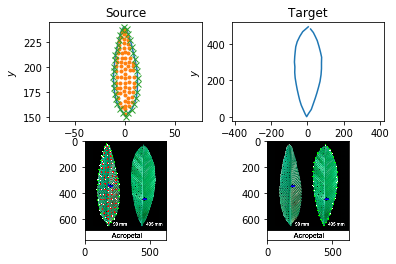

In [3]:
# Some plots
#%matplotlib qt5

plt.subplot(2, 2, 1)
plt.title("Source")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '-')
plt.plot(pos_implicit1[:, 0].numpy(), pos_implicit1[:, 1].numpy(), '.')
plt.plot(pos_implicit0[:, 0].numpy(), pos_implicit0[:, 1].numpy(), 'x')
plt.axis('equal')

plt.subplot(2, 2, 2)
plt.axis(aabb.totuple())
plt.title("Target")
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.plot(pos_target[:, 0].numpy(), pos_target[:, 1].numpy(), '-')
plt.axis('equal')

plt.subplot(2, 2, 3)
plt.imshow(data['source_img'])

plt.subplot(2, 2, 4)
plt.imshow(data['target_img'])

plt.show()

In [4]:
# Setting up the modules

# Global translation module
global_translation = dm.DeformationModules.GlobalTranslation(2)

# Local translation module
sigma0 = 20.
nu0 = 0.001
coeff0 = 10.
implicit0 = dm.DeformationModules.ImplicitModule0(2, pos_implicit0.shape[0], sigma0, nu0, coeff0,  gd=pos_implicit0.clone().requires_grad_())

# Elastic module
sigma1 = 30.
nu1 = 0.0005
coeff1 = 0.01
C = torch.zeros(pos_implicit1.shape[0], 2, 1)
K, L = 10, height_source
a, b = 1./L, 3.
z = a*((pos_implicit1[:, 1] - dec) - Dy)
C[:, 1, 0] = K * ((1 - b) * z**2 + b * z)
C[:, 0, 0] = 0.8 * C[:, 1, 0]
th = 0. * math.pi * torch.ones(pos_implicit1.shape[0])
R = torch.stack([dm.Utilities.rot2d(t) for t in th])

implicit1 = dm.DeformationModules.ImplicitModule1(2, pos_implicit1.shape[0], sigma1, C, nu1, coeff1, gd=(pos_implicit1.clone().requires_grad_(), R.clone().requires_grad_()))

#global_translation.to(device)
#implicit0.to(device)
#implicit1.to(device)

In [5]:
source_deformable = dm.Models.DeformablePoints(pos_source)
target_deformable = dm.Models.DeformablePoints(pos_target)

In [6]:
# Setting up the model and start the fitting loop
#model = dm.Models.RegistrationModel([source_deformable], [implicit0], [dm.Attachment.VarifoldAttachment(2, [20., 200.], backend='torch')], lam=100.)
model = dm.Models.RegistrationModel([source_deformable], [global_translation, implicit0, implicit1], [dm.Attachment.VarifoldAttachment(2, [20., 200.], backend='torch')], lam=100.)
fitter = dm.Models.Fitter(model)

In [7]:
# Setting up the model and start the fitting loop
#model = dm.Models.ModelPointsRegistration([pos_source], [global_translation, implicit0, implicit1], [dm.Attachment.VarifoldAttachment(2, [10., 30., 80.], backend='torch')], lam=50.)

#fitter = dm.Models.ModelFittingScipy(model)

In [8]:
shoot_method = 'euler'
shoot_it = 10

In [9]:
costs = fitter.fit(target_deformable, 40, options={'shoot_method': shoot_method, 'shoot_it': shoot_it})

Starting optimization with method Scipy L-BFGS-B
Initial cost={'deformation': tensor(0.), 'attach': tensor(42128376.)}


../../implicitmodules/torch/Models/optimizer_scipy.py:45: OptimizeWarning: Unknown solver options: shoot_method
  scipy_res = minimize(self.__evaluate(target, shoot_solver, shoot_it), x0, method=self.__scipy_method, jac=self.__need_grad, tol=tol, callback=_post_iteration_callback, options=options)


Time: 5.156211943000017
Iteration: 0
Costs
deformation=429.2776794433594
attach=7074740.0
Total cost=7075169.277679443
Time: 7.639314517999992
Iteration: 1
Costs
deformation=543.6949462890625
attach=5969880.5
Total cost=5970424.194946289
Time: 10.15728696000042
Iteration: 2
Costs
deformation=716.2064819335938
attach=5206385.0
Total cost=5207101.206481934
Time: 12.90756844200041
Iteration: 3
Costs
deformation=800.04296875
attach=5016025.5
Total cost=5016825.54296875
Time: 15.499590148000152
Iteration: 4
Costs
deformation=920.068115234375
attach=4753995.5
Total cost=4754915.568115234
Time: 18.116911594000157
Iteration: 5
Costs
deformation=1190.4598388671875
attach=4244608.0
Total cost=4245798.459838867
Time: 20.62462399700007
Iteration: 6
Costs
deformation=1502.3248291015625
attach=3871556.25
Total cost=3873058.5748291016
Time: 23.240901663000386
Iteration: 7
Costs
deformation=1521.4093017578125
attach=3121558.5
Total cost=3123079.909301758
Time: 28.507767184000386
Iteration: 8
Costs
def

In [10]:

intermediates = {}
deformed = model.compute_deformed(shoot_method, shoot_it, intermediates=intermediates)[0][0].detach()


IndexError: too many indices for tensor of dimension 1

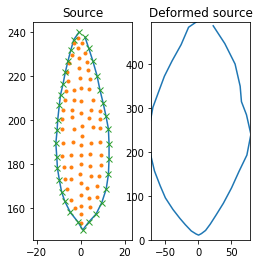

In [11]:
# Results
intermediate_states = intermediates['states']
deformed_source = intermediate_states[-1][0].gd
deformed_implicit0 = intermediate_states[-1][1].gd
#deformed_implicit0 = intermediate_states[-1][2].gd
#deformed_implicit1 = intermediate_states[-1][3].gd[0]

#%matplotlib qt5
plt.subplot(1, 3, 1)
plt.title("Source")
plt.axis(aabb.totuple())
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '-')
plt.plot(pos_implicit1[:, 0].numpy(), pos_implicit1[:, 1].numpy(), '.')
plt.plot(pos_implicit0[:, 0].numpy(), pos_implicit0[:, 1].numpy(), 'x')
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.axis(aabb.totuple())
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.plot(deformed_implicit0[:, 0], deformed_implicit0[:, 1], 'x')
plt.plot(deformed_implicit1[:, 0], deformed_implicit1[:, 1], '.')
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.axis(aabb.totuple())
plt.plot(pos_target[:, 0].numpy(), pos_target[:, 1].numpy(), '-')
plt.plot(deformed_source[:, 0], deformed_source[:, 1], '-')
plt.axis('equal')
plt.show()

In [13]:
# We extract the modules of the models and fill the right manifolds.
silent = dm.DeformationModules.SilentBase(copy.copy(model.init_manifold.clone().manifolds[0]), label='sil')
modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
modules.manifold.fill(model.init_manifold.clone(), copy=True)
deformation_grid = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
CompoundModule = dm.DeformationModules.CompoundModule([deformation_grid] + modules.modules)

In [14]:
intermediates_grid = {}
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(CompoundModule.modules), shoot_method, shoot_it, intermediates=intermediates_grid)

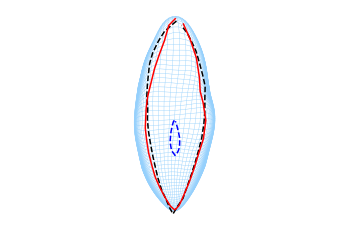

In [15]:
i=-1
f = plt.figure()
ax = f.add_subplot(1,1,1)
deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
deformation_grid_t.manifold.fill_gd(intermediates_grid['states'][i].gd[0].detach())
growth_deformed_grid_t = deformation_grid_t.togrid()
dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
plt.plot(pos_source.detach().numpy()[:,0], pos_source.detach().numpy()[:,1], '--b')
plt.plot(pos_target.detach().numpy()[:,0], pos_target.detach().numpy()[:,1], '--k')
plt.plot(intermediates_grid['states'][i].gd[1].detach().numpy()[:,0], intermediates_grid['states'][i].gd[1].detach().numpy()[:,1], 'r')
plt.axis('equal')
plt.axis('off')
plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'acropetal_deformationmodules.pdf', format='pdf', bbox_inches = 'tight')
#plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'acropetal_classiclargedeformation.pdf', format='pdf', bbox_inches = 'tight')

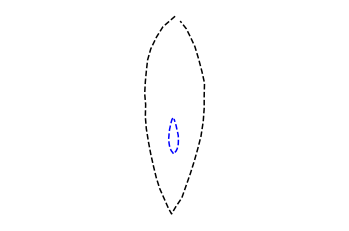

In [16]:
i=0
f = plt.figure()
ax = f.add_subplot(1,1,1)
deformation_grid_t = dm.DeformationModules.DeformationGrid(dm.Utilities.AABB.build_from_points(silent.manifold.gd).scale(1.2).squared(), [64, 64])
deformation_grid_t.manifold.fill_gd(intermediates_grid['states'][i].gd[0].detach())
growth_deformed_grid_t = deformation_grid_t.togrid()
#dm.Utilities.plot_grid(ax, growth_deformed_grid_t[0], growth_deformed_grid_t[1], color='xkcd:light blue', lw=0.4)
plt.plot(pos_source.detach().numpy()[:,0], pos_source.detach().numpy()[:,1], '--b')
plt.plot(pos_target.detach().numpy()[:,0], pos_target.detach().numpy()[:,1], '--k')
#plt.plot(intermediates_grid['states'][i].gd[1].detach().numpy()[:,0], intermediates_grid['states'][i].gd[1].detach().numpy()[:,1], 'r')
plt.axis('equal')
plt.axis('off')
plt.savefig('/home/gris/Results/ImplicitModules/Leaf/' + 'acropetal_boundaries.pdf', format='pdf', bbox_inches = 'tight')

In [11]:
# Results

modules = dm.DeformationModules.CompoundModule(copy.copy(model.modules))
print(len(modules.modules))
modules.manifold.fill(model.init_manifold)
dm.HamiltonianDynamic.shoot(dm.HamiltonianDynamic.Hamiltonian(modules), 10, 'euler')
out = modules.manifold[0].gd.detach().cpu().numpy()
shot_implicit0 = modules.manifold[2].gd.detach().cpu().numpy()
shot_implicit1 = modules.manifold[3].gd[0].detach().cpu().numpy()

%matplotlib qt5
plt.subplot(1, 3, 1)
plt.title("Source")
plt.plot(pos_source[:, 0].numpy(), pos_source[:, 1].numpy(), '-')
plt.plot(pos_implicit1[:, 0].numpy(), pos_implicit1[:, 1].numpy(), '.')
plt.plot(pos_implicit0[:, 0].numpy(), pos_implicit0[:, 1].numpy(), 'x')
plt.axis('equal')

plt.subplot(1, 3, 2)
plt.title("Deformed source")
plt.plot(out[:, 0], out[:, 1], '-')
plt.plot(shot_implicit0[:, 0], shot_implicit0[:, 1], 'x')
plt.plot(shot_implicit1[:, 0], shot_implicit1[:, 1], '.')
plt.axis('equal')

plt.subplot(1, 3, 3)
plt.title("Deformed source and target")
plt.plot(pos_target[:, 0].numpy(), pos_target[:, 1].numpy(), '-')
plt.plot(out[:, 0], out[:, 1], '-')
plt.axis('equal')
plt.show()

4


In [ ]:
# Evolution of the cost with iterations
plt.title("Cost")
plt.xlabel("Iteration(s)")
plt.ylabel("Cost")
plt.plot(range(len(costs)), costs)
plt.show()